In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funciones_analisis import detectar_drift_ks
import drift_tools as dt

In [2]:
# Leer los tres dataframes procesados desde la carpeta 'df_procesados'
df_planta_1 = pd.read_csv('../df_procesados/df_planta_1.csv')
df_planta_2 = pd.read_csv('../df_procesados/df_planta_2.csv')
df_planta_3 = pd.read_csv('../df_procesados/df_planta_3.csv')

In [3]:
df_planta_1['date_time'] = pd.to_datetime(df_planta_1['date_time'])
df_planta_2['date_time'] = pd.to_datetime(df_planta_2['date_time'])
df_planta_3['date_time'] = pd.to_datetime(df_planta_3['date_time'])

# Planta 1

In [ ]:
res = detectar_drift_ks(
df_planta_1,
columnas=[c for c in df_planta_1.select_dtypes('number').columns],
window_days=1, step_days=1,    # <- una ventana por día
min_dias=1,  min_points=800,   # ajusta según tu frecuencia
compare="adjacent",
skip_first_days=2,
alpha=0.005, ks_min=0.15,
fdr=True, min_consecutive=2,
winsor=(0.01, 0.99)        # opcional
)

pd.set_option('display.max_rows', None)
res

,variable,window_start,window_end,ref_start,ref_end,n_ref,n_new,stat,pvalue,drift_detectado,detalle
0,Conductividad DAF,2025-05-24,2025-05-24 23:59:59,2025-05-23,2025-05-23 23:59:59,1374,1333,0.000000,1.000000e+00,False,ok
1,Conductividad DAF,2025-05-25,2025-05-25 23:59:59,2025-05-24,2025-05-24 23:59:59,1333,1380,0.000000,1.000000e+00,False,ok
2,Conductividad DAF,2025-05-26,2025-05-26 23:59:59,2025-05-25,2025-05-25 23:59:59,1380,1379,0.000000,1.000000e+00,False,ok
3,Conductividad DAF,2025-05-27,2025-05-27 23:59:59,2025-05-26,2025-05-26 23:59:59,1379,1374,0.000000,1.000000e+00,False,ok
4,Conductividad DAF,2025-05-28,2025-05-28 23:59:59,2025-05-27,2025-05-27 23:59:59,1374,1377,0.000000,1.000000e+00,False,ok
5,Conductividad DAF,2025-05-29,2025-05-29 23:59:59,2025-05-28,2025-05-28 23:59:59,1377,1373,0.418063,4.264737e-108,True,ok
6,Conductividad DAF,2025-05-30,2025-05-30 23:59:59,2025-05-29,2025-05-29 23:59:59,1373,1367,0.847041,0.000000e+00,True,ok
7,Conductividad DAF,2025-05-31,2025-05-31 23:59:59,2025-05-30,2025-05-30 23:59:59,1367,1369,0.904259,0.000000e+00,True,ok
8,Conductividad DAF,2025-06-01,2025-06-01 23:59:59,2025-05-31,2025-05-31 23:59:59,1369,1376,0.847835,0.000000e+00,True,ok
9,Conductividad DAF,2025-06-02,2025-06-02 23:59:59,2025-06-01,2025-06-01 23:59:59,1376,1373,0.474876,6.488610e-141,True,ok


In [22]:
res["drift_detectado"].value_counts()

drift_detectado
True     583
False    290
Name: count, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# --- fusiona ventanas consecutivas con drift para sombrear bloques limpios
def _drift_blocks(res, var):
    sub = res[(res["variable"] == var) & (res["detalle"] == "ok")].copy()
    if sub.empty: 
        return []
    sub = sub.sort_values("window_start")
    blocks, open_s, open_e = [], None, None
    for _, r in sub.iterrows():
        if bool(r.get("drift_detectado", False)):
            s, e = pd.to_datetime(r["window_start"]), pd.to_datetime(r["window_end"])
            if open_s is None:
                open_s, open_e = s, e
            else:
                if s <= open_e + pd.Timedelta(seconds=1):
                    open_e = max(open_e, e)
                else:
                    blocks.append((open_s, open_e))
                    open_s, open_e = s, e
        else:
            if open_s is not None:
                blocks.append((open_s, open_e)); open_s, open_e = None, None
    if open_s is not None:
        blocks.append((open_s, open_e))
    return blocks

# --- una figura para una variable
def plot_ks_one(df, res, fecha_col, var, resample="15min",
                shade_color="tab:red", shade_alpha=0.22,
                line_kwargs=None):
    d = df[[fecha_col, var]].dropna().sort_values(fecha_col)
    s = d.set_index(fecha_col)[var].resample(resample).median().dropna().reset_index()
    blocks = _drift_blocks(res, var)

    plt.figure(figsize=(12, 4))
    plt.plot(s[fecha_col], s[var], **(line_kwargs or {}))
    for s0, s1 in blocks:
        plt.axvspan(s0, s1, color=shade_color, alpha=shade_alpha)
    n_blocks = len(blocks)
    plt.title(f"Serie – {var}  (bloques con drift: {n_blocks})")
    plt.xlabel("Tiempo"); plt.ylabel(var); plt.tight_layout(); plt.show()

# --- galería: muchas variables en grilla
def plot_ks_gallery(df, res, fecha_col, variables=None, resample="15min",
                    ncols=2, height_per_row=2.6, only_with_drift=True):
    if variables is None:
        variables = res["variable"].dropna().unique().tolist()
    if only_with_drift:
        have = res[(res["detalle"]=="ok") & (res["drift_detectado"]==True)]["variable"].unique().tolist()
        variables = [v for v in variables if v in have]

    n = len(variables)
    if n == 0:
        print("No hay variables con drift para mostrar."); 
        return

    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, height_per_row*nrows), squeeze=False)
    axes = axes.flatten()

    # ordenar por # de ventanas con drift (desc)
    counts = (res[(res["detalle"]=="ok") & (res["drift_detectado"]==True)]
              .groupby("variable", as_index=False).size()
              .sort_values("size", ascending=False))
    order = counts["variable"].tolist()
    variables = sorted(variables, key=lambda v: order.index(v) if v in order else 1e9)

    for i, var in enumerate(variables):
        ax = axes[i]
        d = df[[fecha_col, var]].dropna().sort_values(fecha_col)
        s = d.set_index(fecha_col)[var].resample(resample).median().dropna().reset_index()
        ax.plot(s[fecha_col], s[var])
        for s0, s1 in _drift_blocks(res, var):
            ax.axvspan(pd.to_datetime(s0), pd.to_datetime(s1), color="tab:red", alpha=0.22)
        n_blocks = len(_drift_blocks(res, var))
        ax.set_title(f"{var}  (bloques: {n_blocks})", fontsize=10)
        ax.set_xlabel("Tiempo"); ax.set_ylabel(var)
    # apaga ejes sobrantes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout(); plt.show()

# --- barra horizontal con conteos por variable (útil para elegir TOP-N)
def plot_ks_counts(res, top=None):
    counts = (res[(res["detalle"]=="ok") & (res["drift_detectado"]==True)]
              .groupby("variable", as_index=False)
              .size()
              .sort_values("size", ascending=True))
    if top: counts = counts.tail(top)
    plt.figure(figsize=(8, max(2, 0.35*len(counts))))
    plt.barh(counts["variable"], counts["size"])
    plt.title("Ventanas con drift por variable")
    plt.xlabel("# ventanas"); plt.tight_layout(); plt.show()


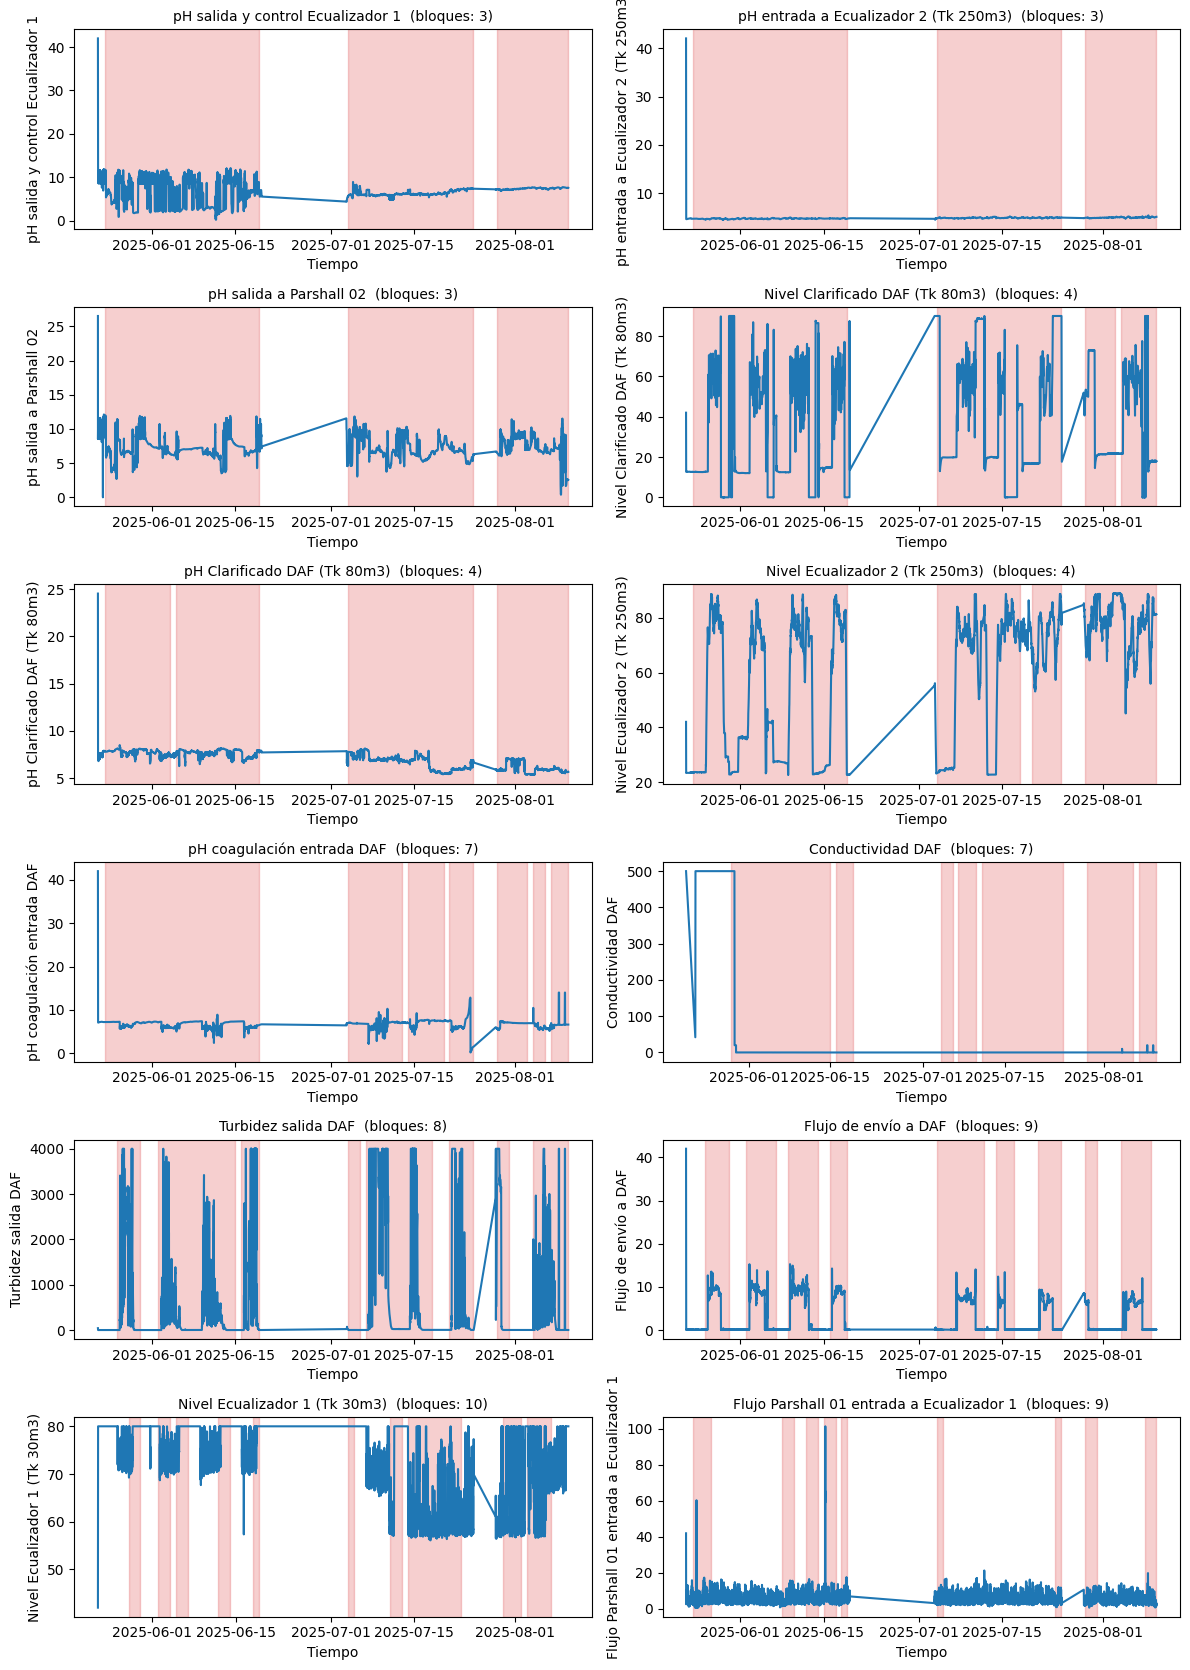

In [24]:
# 1) Galería de TODAS las variables que tienen drift
plot_ks_gallery(df_planta_1, res, "date_time", resample="10min", ncols=2, height_per_row=2.8, only_with_drift=True)

## Ventanas de Proceso Activo

In [8]:
FECHA = "date_time"

# ---------------------------
# 1) Bandera de "proceso activo"
# ---------------------------
def build_active_flag(
    df: pd.DataFrame,
    fecha_col: str,
    rules: dict,
    smooth_window: int = 15,       # ~15 min si tienes dato por minuto
    min_block_len: int = 10        # descarta bloques < 10 muestras
) -> pd.Series:
    """
    rules: diccionario {nombre_variable: {"op": ">", "thr": valor}} o {"op": "diff>", "thr": valor}
           Soporta:
             - ">"  : variable > thr
             - "<"  : variable < thr
             - "diff>" : |diff(variable)| > thr  (movimiento)
    """
    df2 = df.copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)

    conds = []
    for col, spec in rules.items():
        op = spec.get("op", ">")
        thr = spec.get("thr", 0)
        if col not in df2.columns:
            continue
        s = df2[col]
        if op == ">":
            c = s > thr
        elif op == "<":
            c = s < thr
        elif op == "diff>":
            c = s.diff().abs() > thr
        else:
            raise ValueError(f"Operador no soportado: {op}")
        conds.append(c.fillna(False))

    if not conds:
        return pd.Series(False, index=df2.index, name="proceso_activo")

    raw = np.logical_or.reduce(conds)

    # Suavizado para evitar parpadeos (cierre morfológico sencillo)
    smooth = pd.Series(raw, index=df2.index).rolling(smooth_window, min_periods=1).max().astype(bool)

    # Enforce min_block_len: elimina bloques muy cortos (ruido)
    flag = smooth.copy()
    run_start = None
    for i, v in enumerate(flag.values):
        if v and run_start is None:
            run_start = i
        if (not v or i == len(flag)-1) and run_start is not None:
            end = i if not v else i  # cierre
            length = end - run_start + (1 if v and i == len(flag)-1 else 0)
            if length < min_block_len:
                flag.iloc[run_start:end] = False
            run_start = None

    flag.name = "proceso_activo"
    return flag

# ---------------------------
# 2) Bloques (start, end) desde la bandera
# ---------------------------
def blocks_from_flag(df: pd.DataFrame, fecha_col: str, flag: pd.Series) -> pd.DataFrame:
    df2 = df.copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)
    f = flag.reindex(df2.index).fillna(False).values

    starts, ends = [], []
    in_block = False
    for i, v in enumerate(f):
        if v and not in_block:
            starts.append(df2[fecha_col].iloc[i])
            in_block = True
        if not v and in_block:
            ends.append(df2[fecha_col].iloc[i-1])
            in_block = False
    if in_block:
        ends.append(df2[fecha_col].iloc[-1])

    return pd.DataFrame({"start": starts, "end": ends})

# ---------------------------
# 3) Graficar con sombreado de ventanas activas
# ---------------------------
def plot_with_active_blocks(
    df: pd.DataFrame,
    fecha_col: str,
    col: str,
    blocks: pd.DataFrame,
    resample: str = "15min",
    color: str = "tab:red",
    alpha: float = 0.18,
    show_points: bool = False
):
    df2 = df[[fecha_col, col]].dropna().copy()
    df2[fecha_col] = pd.to_datetime(df2[fecha_col])
    df2 = df2.sort_values(fecha_col)

    if resample is not None:
        s = (df2.set_index(fecha_col)[col]
                .resample(resample).median().dropna().reset_index())
    else:
        s = df2.rename(columns={col: "value"}).rename(columns={"value": col})

    plt.figure(figsize=(12, 4))
    if show_points:
        plt.plot(s[fecha_col], s[col], marker='.', linestyle='None', markersize=2)
    else:
        plt.plot(s[fecha_col], s[col])

    for _, r in blocks.iterrows():
        plt.axvspan(pd.to_datetime(r["start"]), pd.to_datetime(r["end"]), color=color, alpha=alpha)

    plt.title(f"Serie de tiempo – {col} (ventanas ACTIVAS sombreadas)")
    plt.xlabel("Tiempo"); plt.ylabel(col); plt.tight_layout(); plt.show()


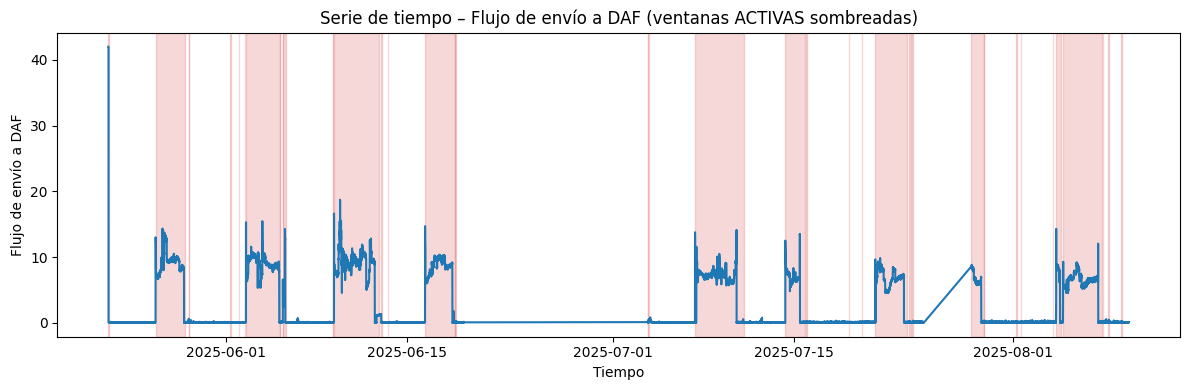

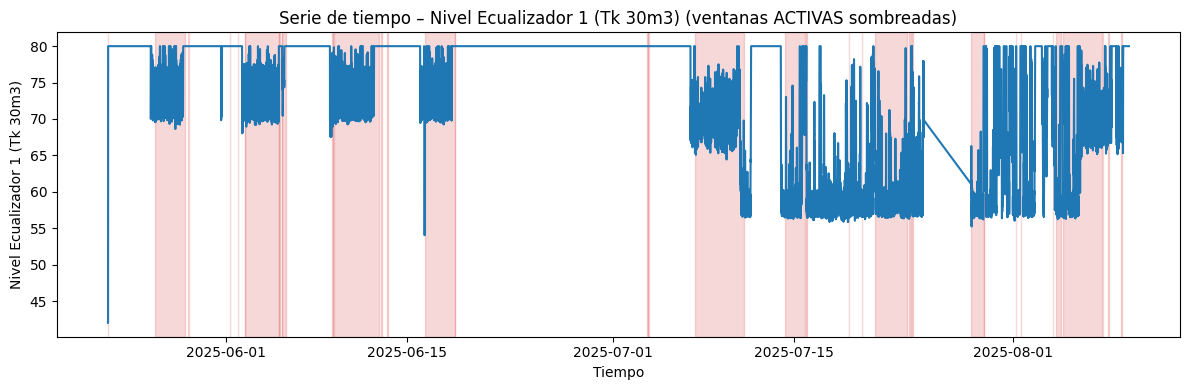

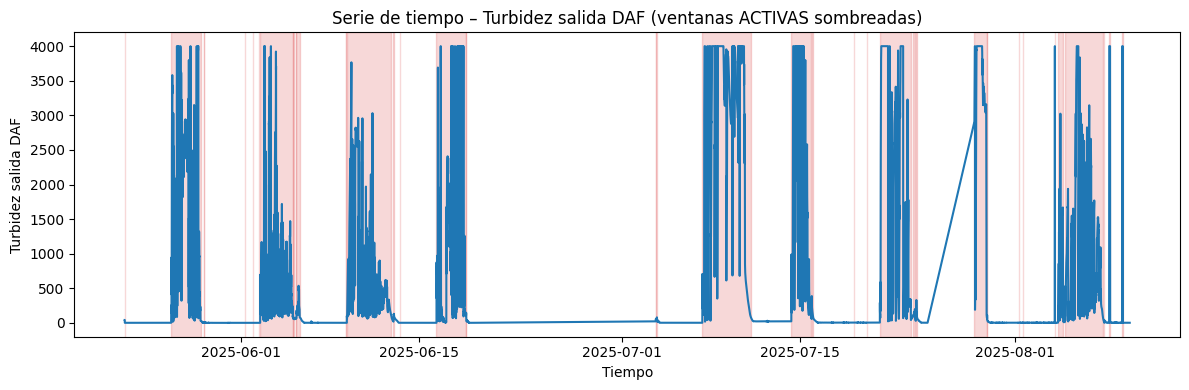

In [9]:
df = df_planta_1.copy()
df[FECHA] = pd.to_datetime(df[FECHA])

# Reglas de activación (OR entre reglas)
rules = {
    "Flujo de envío a DAF": {"op": ">", "thr": 2},
    "Turbidez salida DAF": {"op": ">", "thr": 100},
    "Nivel Ecualizador 2 (Tk 250m3)": {"op": "diff>", "thr": 1.0},  # movimiento
}

flag = build_active_flag(df, FECHA, rules, smooth_window=15, min_block_len=10)
blocks_activos = blocks_from_flag(df, FECHA, flag)

# Ver rápidamente si marca bien en 3 variables clave:
for col in [
    "Flujo de envío a DAF",
    "Nivel Ecualizador 1 (Tk 30m3)",
    "Turbidez salida DAF",
]:
    plot_with_active_blocks(df, FECHA, col, blocks_activos, resample="5min")


# Planta 2

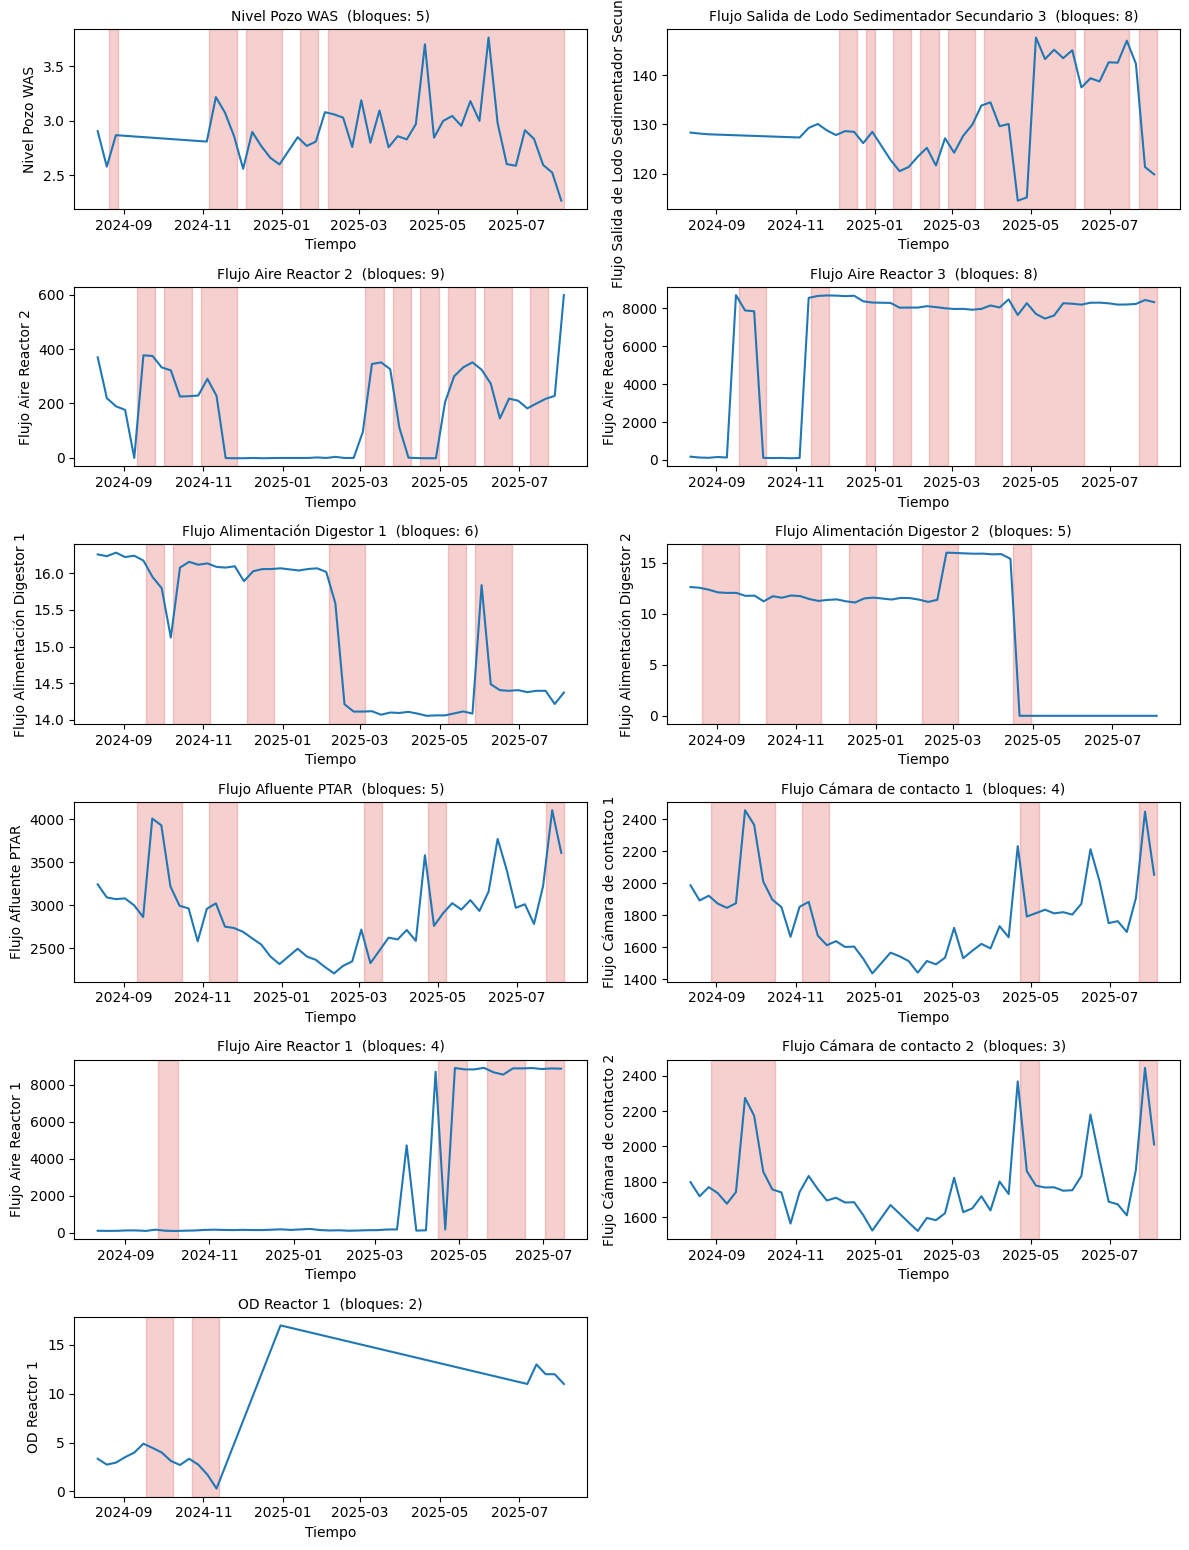

In [26]:
cols2 = df_planta_2.select_dtypes('number').columns.tolist()

res2 = detectar_drift_ks(
    df_planta_2, columnas=cols2,
    window_days=7, step_days=7,   # semanal, sin solape
    min_dias=5, min_points=1200,  # ~200 pts/día * 5 días
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)

# visual semanal
plot_ks_gallery(df_planta_2, res2, "date_time", resample="7D", ncols=2)


# Planta 3

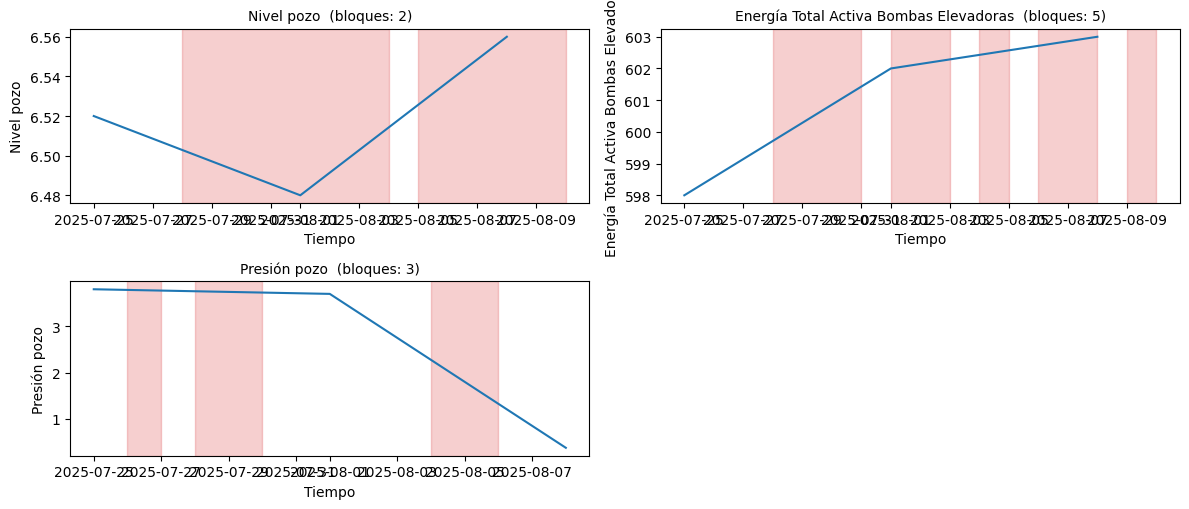

In [ ]:
cols3 = df_planta_3.select_dtypes('number').columns.tolist()

res3 = detectar_drift_ks(
    df_planta_3, columnas=cols3,
    window_days=7, step_days=7,
    min_dias=5, min_points=7000,  # ~1.4k pts/día * 5 días ≈ 7k
    compare="adjacent",
    skip_first_days=1,            # evita sesgo del arranque sin perder ventanas
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=1,  # clave por horizonte corto
    winsor=(0.01, 0.99)
)

plot_ks_gallery(df_planta_3, res3, "date_time", resample="7D", ncols=2)
